# Example usage of TFS

In [1]:
import numpy as np
import pta
import enkie
import matplotlib.pyplot as plt
import math

from pta.sampling.tfs import (
    TFSModel,
    sample_drg,
    sample_drg0_from_drg,
    sample_log_conc_from_drg,
    sample_fluxes_from_drg
)

### Load an SBML model and create its thermodynamic space.

In [ ]:
model = pta.load_example_model("e_coli_core")
model.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = 0.5
pta.prepare_for_pta(model)

concentrations = pta.ConcentrationsPrior.load('M9_aerobic')
concentrations.add(pta.ConcentrationsPrior.load('ecoli_M9_glc'))
compartment_parameters = enkie.CompartmentParameters.load("e_coli")

thermodynamic_space = pta.ThermodynamicSpace.from_cobrapy_model(
    model,
    metabolites_namespace = "bigg.metabolite",
    parameters=compartment_parameters,
    concentrations=concentrations
)

### Sample the reaction energies of the network.

The remaining quantities (concentrations, standard reaction energies and fluxes) are conditioned on the reaction energies and can be sampled faster in a second step.

In [3]:
tfs_model = TFSModel(model, thermodynamic_space, solver="GUROBI")
result = sample_drg(tfs_model)

### Sample concentrations, standard reaction energies and fluxes.

In [4]:
log_conc = sample_log_conc_from_drg(thermodynamic_space, result.samples)
drg0 = sample_drg0_from_drg(thermodynamic_space, result.samples)
fluxes = sample_fluxes_from_drg(model, result.samples, result.orthants)

## Plot the predicted distributions

In [5]:
def plot_samples(samples, x_log = False):
    num_plots = samples.shape[1]
    n_cols = 8
    n_rows = math.ceil(num_plots / n_cols)

    fig=plt.figure(figsize=(16, 1.6*n_rows))
    for i in range(num_plots):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        if x_log:
            hist, bins = np.histogram(samples.iloc[:,i], bins=20)
            logbins = np.logspace(np.log(bins[0]), np.log(bins[-1]), len(bins), base=np.e)
            ax.hist(samples.iloc[:,i], bins=logbins)
            plt.xscale('log')
        else:
            ax.hist(samples.iloc[:,i], bins=20, density=True)
        ax.set_title(samples.columns[i])
    fig.tight_layout()
    plt.show()

### Reaction energies

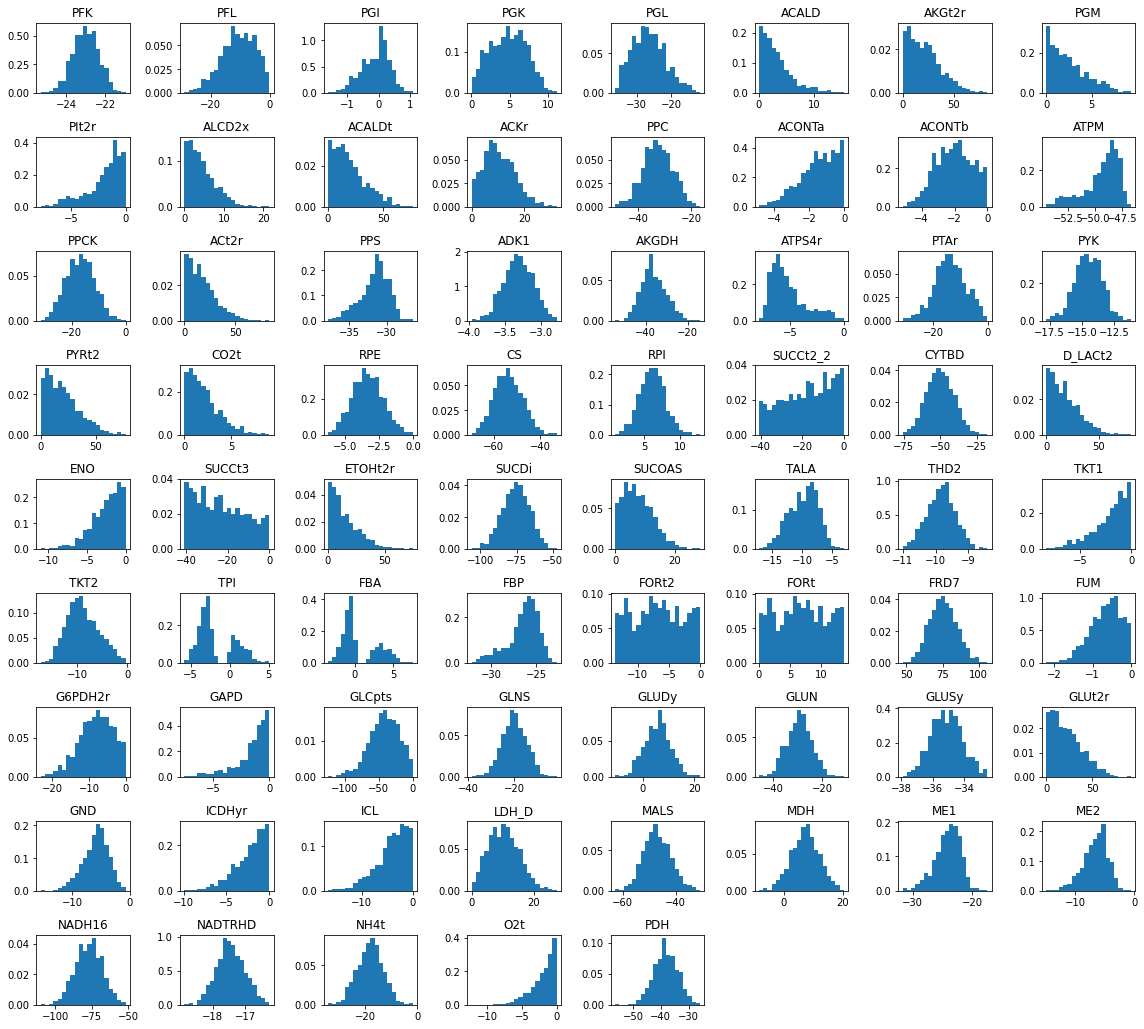

In [6]:
plot_samples(result.samples)

### Metabolite concentrations

C:\Users\matti\AppData\Local\Temp\ipykernel_27372\3382507873.py:11: RuntimeWarning: invalid value encountered in log
  logbins = np.logspace(np.log(bins[0]), np.log(bins[-1]), len(bins), base=np.e)


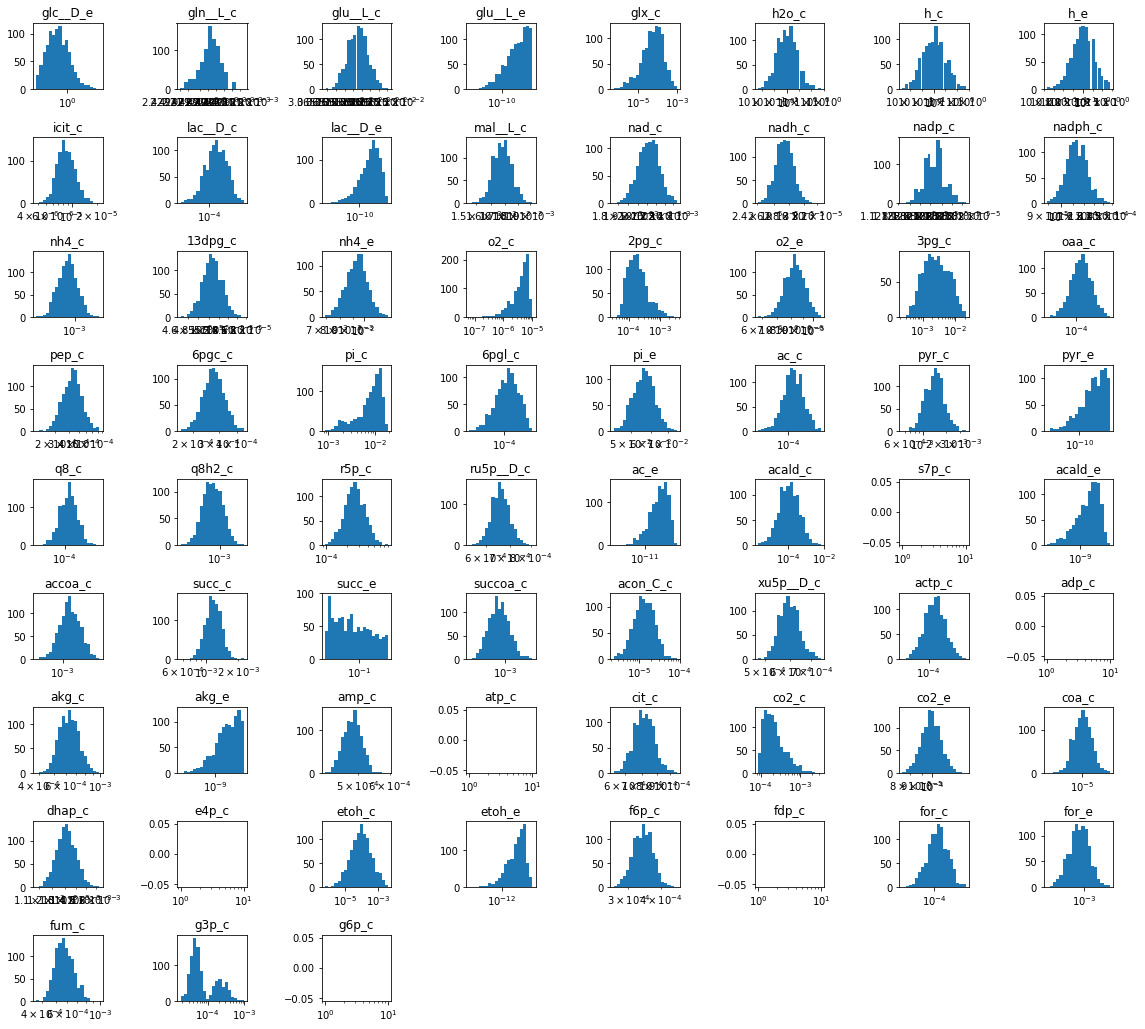

In [7]:
plot_samples(np.exp(log_conc), x_log=True)

### Standard reaction energies

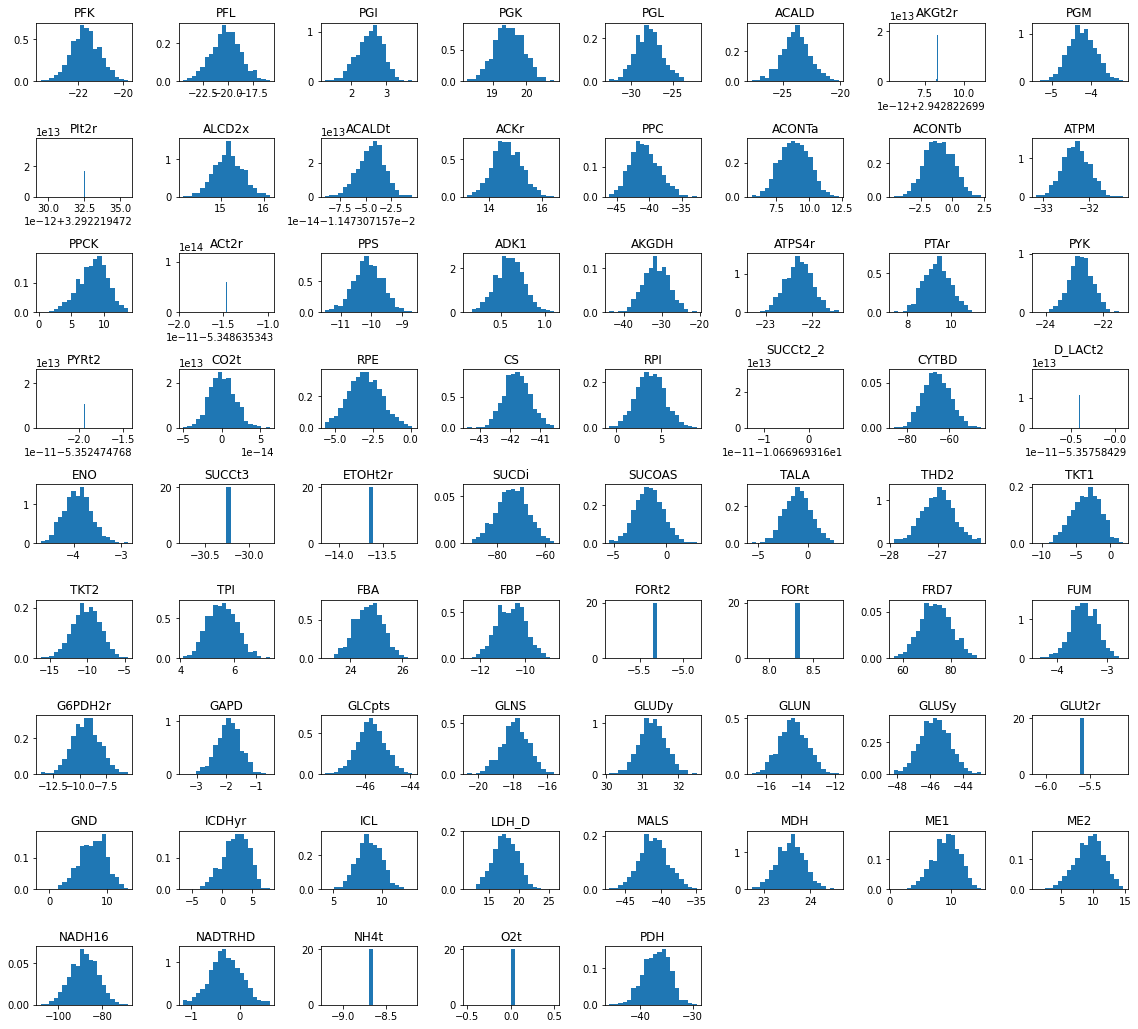

In [8]:
plot_samples(drg0)

### Fluxes

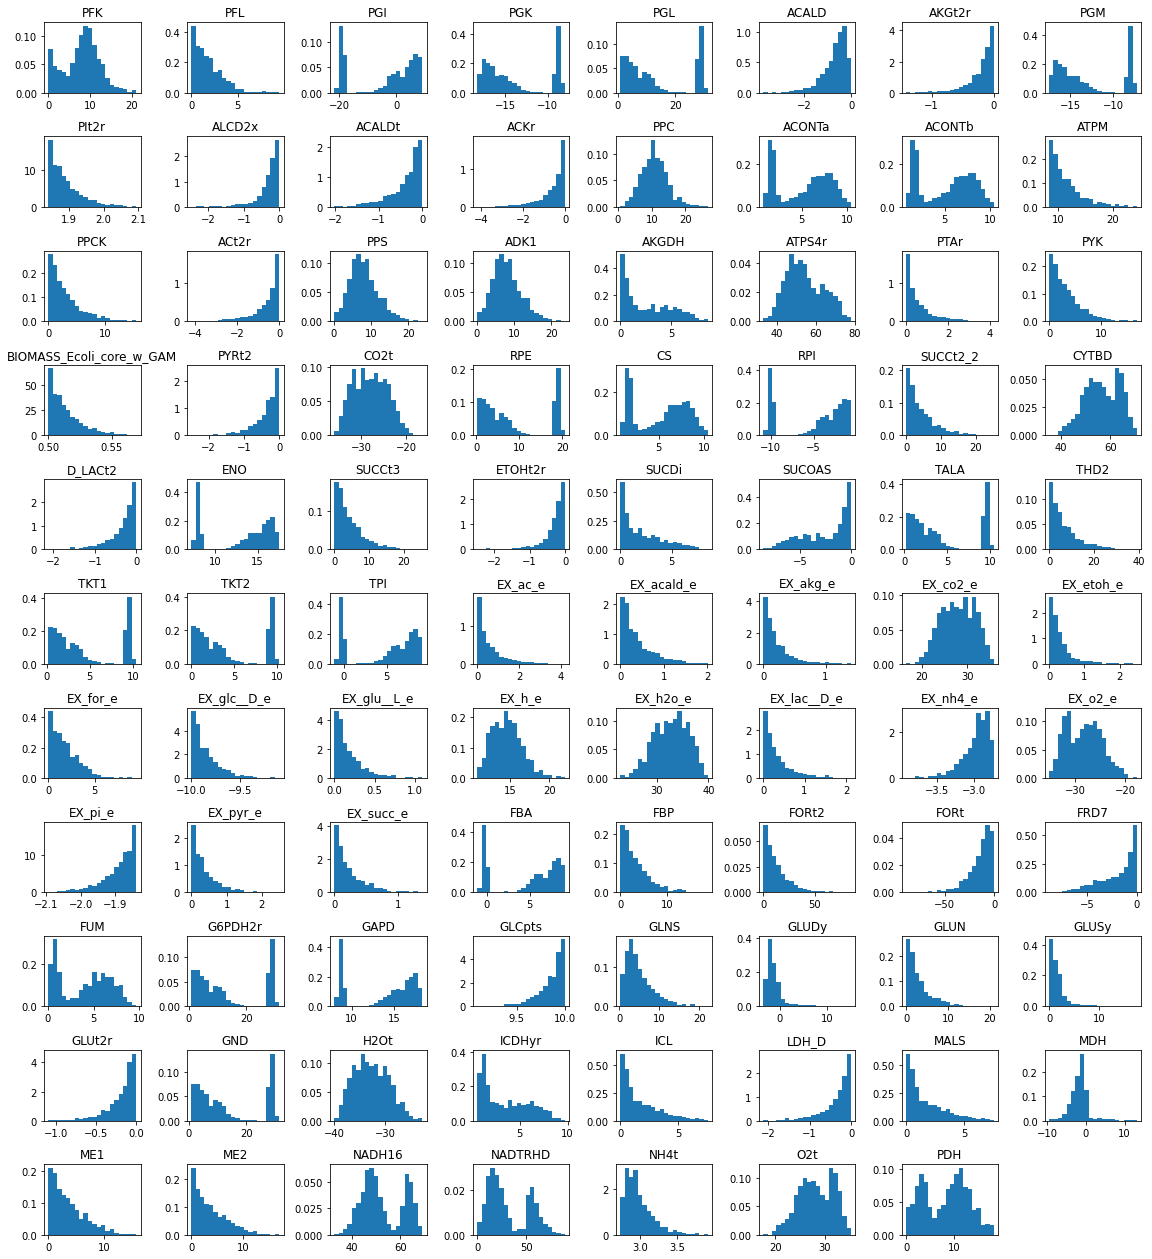

In [9]:
plot_samples(fluxes)